In [5]:
from Research_Scraper_Code.Research_Scraper import ResearchScraper
from Research_Scraper_Code import utils
import pandas as pd
import time
import json
import urllib.parse

# Scraping X CRIS
Demo Links

In [2]:
# test urls
url_ieee = 'https://ieeexplore.ieee.org/document/7887648'
url_springer = 'https://link.springer.com/article/10.1007/s12525-020-00445-0'
url_doi = 'https://doi.org/10.1007/978-0-387-73947-2_8'
url_elsevier = 'https://www.sciencedirect.com/science/article/pii/S2451929420300851?via%3Dihub'
url_springer2 = 'https://doi.org/10.1007/s00450-009-0054-z'

### Init scraper and load the publications from the csv

In [3]:
scraper = ResearchScraper()

In [6]:
def load_publications_from_csv():
    data = 'data/publications_without_abstract.csv'

    with open(data) as f:
        df = pd.read_csv(f, sep=';')
    return df


df_publications = load_publications_from_csv()

Get entries with DOI for scraping

## Scraping utils

In [7]:
def get_all_dois(df):
    dois = df['doi']
    # remove NaNs
    dois = dois.dropna()
    dois.tolist()
    return dois


publication_dois = get_all_dois(df_publications)

Method for creating JSON file as output

In [6]:
#utils.write_results(result, name)

Create a sample of cris data and scrape them al

In [7]:
def scrape_sample_of_dois(dois, n):
    """
    Chooses random n entries from the list of dois and scrapes them. For debugging purposes
    :param dois: list of dois to sample from
    :param n: size of the sample
    :return: results of the scraping
    """
    # get a sample of 10 from dois
    sample = dois.sample(n)
    #print(sample)
    results = []

    for doi in sample:
        print(f'Scraping {doi}')
        start = time.time()
        result = scraper.scrape_publication_by_doi(doi, params=['full'])
        end = time.time()
        print(f'Total time : {end - start}')
        old_len = len(results)
        results.append(result)
        print(f'\n \t  >>>>>> added new result, n went from {old_len} to n={len(results)}')
        # print(f'\t -> Results: {results}')

    #write_results(results, f'sample_{time.strftime("%Y_%m_%d__%H_%M")}')
    return results


In [64]:
# scrape sample of 3
res = None
res = scrape_sample_of_dois(publication_dois, 3)
utils.write_results(res, f'sample_scrapings_{time.strftime("%Y_%m_%d__%H_%M")}')

Scraping 10.1007/978-3-7908-2056-0_1
URL ('https://doi.org/10.1007/978-3-7908-2056-0_1') is a DOI link, Links is now resolved properly
Resolved DOI link to: https://link.springer.com/chapter/10.1007/978-3-7908-2056-0_1
[DEBUG - ResearchScraper] - Found scraper for https://link.springer.com/chapter/10.1007/978-3-7908-2056-0_1 -> ScraperSpringer
200
Error: No keywords found
Error: try clause in chapter
Total time : 1.9580090045928955

 	  >>>>>> added new result, n went from 0 to n=1
Scraping 10.1109/ICT-DM.2017.8275681
URL ('https://doi.org/10.1109/ICT-DM.2017.8275681') is a DOI link, Links is now resolved properly
Resolved DOI link to: https://ieeexplore.ieee.org/document/8275681/
[DEBUG - ResearchScraper] - Found scraper for https://ieeexplore.ieee.org/document/8275681/ -> ScraperIEEE
200
Total time : 2.858159065246582

 	  >>>>>> added new result, n went from 1 to n=2
Scraping 10.1080/13504851.2017.1397846
URL ('https://doi.org/10.1080/13504851.2017.1397846') is a DOI link, Links is 

Scraping a list of DOIs

In [8]:
def scrape_publication_by_doi_list(doi_list, params=['full']):
    print(f'Time of scrape start: {time.strftime("%Y_%m_%d__%H_%M")}')
    results = []
    for doi in doi_list:
        print(f'>>> Scraping {doi}')
        result = scraper.scrape_publication_by_doi(doi, params)
        print(f'>>>> Scraping {doi} done')
        results.append(result)
        print(f'>>>> Scraping {doi} added to results')
    print(f'>>>> Scraping {len(doi_list)} publications done')
    utils.write_results(results, f'scrapings_{time.strftime("%Y_%m_%d__%H_%M")}')
    print(f'Time of scrape end: {time.strftime("%Y_%m_%d__%H_%M")}')
    return results

In [17]:
# Draw a sample list and scrape them
doi_list_sample = publication_dois.sample(10)
scraping_results = scrape_publication_by_doi_list(doi_list_sample)
len(scraping_results)

>>> Scraping 10.1509/jmkg.72.2.1
URL ('https://doi.org/10.1509/jmkg.72.2.1') is a DOI link, Links is now resolved properly
Resolved DOI link to: https://journals.sagepub.com/doi/10.1509/jmkg.72.2.1
[DEBUG - ResearchScraper] - No scraper found for https://journals.sagepub.com/doi/10.1509/jmkg.72.2.1
>>>> Scraping 10.1509/jmkg.72.2.1 done
>>>> Scraping 10.1509/jmkg.72.2.1 added to results
>>>> Scraping 1 publications done


1

## Importing results of scraping

In [9]:
# read json file with scraping results (all cris doi numbers)
with open('exports/scrapings/scrapings_2022_10_16__07_09.json') as f:
    scraping_results_imported_old = json.load(f)

with open('exports/scrapings/scrapings_2022_10_21__03_38.json') as f:
    scraping_results_imported = json.load(f)

# old file 582 after clean

In [10]:
# drop Nones and errors from dict
scraping_results_imported_cleaned = [x for x in scraping_results_imported if x is not None and x.get('error') is None]
# old file 582 after clean

# files without Nones

In [11]:
# get the rows from the dict with the key 'error'
error_rows = [x for x in scraping_results_imported if x is not None and x.get('error') is not None]
error_rows_unknown = [x for x in error_rows if x.get('error') != 'No scraper found for this url']

Searching for a specific publication by a link

In [12]:
# search entry with title containing The absent-minded prisoner


[x for x in scraping_results_imported_cleaned if
 x.get('url') == urllib.parse.unquote('https://link.springer.com/article/10.1007%2Fs12599-019-00623-1')]


[{'url': 'https://link.springer.com/article/10.1007/s12599-019-00623-1',
  'title': 'Standardization of Forms in Governments',
  'doi': '10.1007/s12599-019-00623-1',
  'authors': [{'name': 'Hendrik Scholta', 'orcid': None},
   {'name': 'Dian Balta', 'orcid': None},
   {'name': 'Michael Räckers', 'orcid': None},
   {'name': 'Jörg Becker', 'orcid': None},
   {'name': 'Helmut Krcmar', 'orcid': None}],
  'keywords': ['Reference modeling',
   'Forms',
   'Standardization',
   'E-government',
   'Digital government',
   'Public administration',
   'Meta-modeling',
   'Graphical user interface'],
  'abstract': 'Forms are central interfaces for information exchange between a government and its citizens. As a way to translate laws into practice, forms are an essential part facilitating this exchange. Unfortunately, forms often require substantial development effort to ensure they comply with legal requirements, with the result that citizens often describe them as highly complex. Standardization

With the scraper we can fill missing keywords

In [ ]:
scraper = ResearchScraper()
link = 'https://link.springer.com/article/10.1007%2Fs12599-019-00623-1'
result = scraper.scrape_publication_by_url(link, params=['full']).get('keywords')
result

In [8]:
# decode url, useful for taking URLs from cris as search query
urllib.parse.unquote('https://link.springer.com/article/10.1007/s12599-019-00623-1')

'https://link.springer.com/article/10.1007/s12599-019-00623-1'

## Cris data exploration

Searching for publications that are not complete

In [57]:
# filter df_publications url not nan and doi not nan
#df_publications_filtered = df_publications[df_publications['url'].notna() & df_publications['doi'].notna()]
# filter rows with nan in keywords
df_publications_filtered = df_publications[df_publications['keywords'].isna()]
# filter rows where 'Springer' is in url
df_publications_filtered = df_publications_filtered[(df_publications_filtered['url'].str.contains('link.springer')) | (
    df_publications_filtered['url'].str.contains('sciencedirect')) | (
                                                        df_publications_filtered['url'].str.contains('ieeexplore'))]
df_publications_filtered


,id,cris_id,cris_c4_id,title,subtitle,title_in_source,language,external,content_type,peer_reviewed,...,title_of_series,place,publisher,isbn,doi,url,authors,strings,sort_order,client_purpose
1703,22913,17292119,22913,Tracking down the business cycle: A dynamic fa...,NaN,NaN,English,NaN,NaN,Ja,...,NaN,NaN,NaN,NaN,10.1016/j.eeh.2009.04.002,http://www.sciencedirect.com/science?_ob=Artic...,"Sarferaz S, Uebele M","[[[entry:ApaHtml]]]Sarferaz, S., & Uebele, M. ...","7990-1060-Sarferaz S, Uebele M",NaN
1797,25524,17456544,25524,The Dynamic of Bicycle Finals: A Theoretical a...,NaN,NaN,English,Ja,NaN,Ja,...,NaN,Münster,NaN,NaN,10.1016/S0313-5926(09)50037-9,http://www.sciencedirect.com/science/article/p...,"Dilger Alexander, Geyer Hannah","[[[entry:ApaHtml]]]Dilger, A., & Geyer, H. (20...","7990-1060-Dilger Alexander, Geyer Hannah",NaN
2258,30720,17807442,30720,The Absent-Minded Prisoner,NaN,NaN,English,Ja,NaN,Ja,...,NaN,NaN,NaN,NaN,10.1007/s10108-006-9011-1,http://link.springer.com/article/10.1007%2Fs10...,Dilger Alexander,"[[[entry:ApaHtml]]]Dilger, A. (2006). The Abse...",7993-1060-Dilger Alexander,NaN
2737,46125,18894525,46125,Rankings von Zeitschriften und Personen in der...,NaN,NaN,German,Ja,NaN,Ja,...,NaN,Münster,NaN,NaN,10.1007/s12354-010-0119-8,http://link.springer.com/article/10.1007%2Fs12...,Dilger Alexander,"[[[entry:ApaHtml]]]Dilger, A. (2010). Rankings...",7989-1060-Dilger Alexander,NaN
2914,48566,19063464,48566,Arbeitsmarktregulierung und nachvertraglicher ...,NaN,NaN,German,Nein,NaN,Ja,...,NaN,NaN,NaN,NaN,10.1007/978-3-663-07711-4_9,http://link.springer.com/chapter/10.1007%2F978...,"Frick Bernd, Dilger Alexander, Prinz Joachim","[[[entry:ApaHtml]]]Frick, B., Dilger, A., & Pr...","7997-1060-Frick Bernd, Dilger Alexander, Prinz...",NaN
4133,80987,21568164,80987,Why Social Currency Becomes a Key Driver of a ...,NaN,NaN,English,Ja,NaN,Ja,...,NaN,NaN,NaN,NaN,10.1016/j.lrp.2012.11.004,http://www.sciencedirect.com/science/article/p...,"Lobschat L, Zinnbauer MA, Pallas F, Joachimsth...","[[[entry:ApaHtml]]]Lobschat, L., Zinnbauer, M....","7986-1060-Lobschat L, Zinnbauer MA, Pallas F, ...",NaN
4872,92164,20829855,92164,Graph Theory and Model Collection Management –...,NaN,NaN,English,Ja,NaN,Ja,...,NaN,NaN,NaN,NaN,10.1007/s10257-014-0243-6,http://link.springer.com/article/10.1007/s1025...,"Breuker Dominic, Delfmann Patrick, Dietrich Ha...","[[[entry:ApaHtml]]]Breuker, D., Delfmann, P., ...","7984-1060-Breuker Dominic, Delfmann Patrick, D...",NaN
5386,99652,20345089,99652,Bitcoin: A First Legal Analysis – with referen...,NaN,NaN,English,Ja,NaN,Ja,...,NaN,NaN,NaN,NaN,10.1007/978-3-662-44774-1_4,http://link.springer.com/chapter/10.1007%2F978...,"Boehm, Pesch","[[[entry:ApaHtml]]]Boehm, P. (2014). Bitcoin: ...","7985-1040-Boehm, Pesch",NaN
5429,101077,20258749,101077,Improving the State of the Art in Inexact TSP ...,NaN,NaN,English,Ja,NaN,Ja,...,NaN,Cham,Springer International Publishing,NaN,10.1007/978-3-319-19084-6_18,http://download.springer.com/static/pdf/93/chp...,"Kotthoff Lars, Kerschke Pascal, Hoos Holger H,...","[[[entry:ApaHtml]]]Kotthoff, L., Kerschke, P.,...","7984-1040-Kotthoff Lars, Kerschke Pascal, Hoos...",NaN
5628,104246,20053043,104246,Extending Battery Management Systems for Makin...,NaN,NaN,English,Ja,NaN,Ja,...,Lecture Notes in Computer Science,NaN,Springer International Publishing,NaN,10.1007/978-3-319-18714-3_37,https://link.springer.com/content/pdf/10.1007%...,"Monhof Markus, Beverungen Daniel, Klör Benjami...","[[[entry:ApaHtml]]]Monhof, M., Beverungen, D.,...","7984-1040-Monhof Markus, Beverungen Daniel, Kl...",NaN


1623 entries with DOI

In [28]:
# filter where doi not nan
df_publications_filtered = df_publications[df_publications['doi'].notna()]
df_publications_filtered.shape

(1623, 46)

675 with URL

In [29]:
# filter where url not nan
df_publications_filtered = df_publications_filtered[df_publications_filtered['url'].notna()]
df_publications_filtered.shape

(675, 46)

948 entries only with doi

In [35]:
df_publications_filtered = df_publications[df_publications['doi'].notna() & df_publications['url'].isna()]
df_publications_filtered.shape
df_publications_filtered

,id,cris_id,cris_c4_id,title,subtitle,title_in_source,language,external,content_type,peer_reviewed,...,title_of_series,place,publisher,isbn,doi,url,authors,strings,sort_order,client_purpose
2,2793,12236895,2793,Language Theories in IS Research – A Review,NaN,NaN,English,Ja,NaN,Nein,...,NaN,Heidelberg,Physica-Verlag,978-3-7908-2335-6,10.1007/978-3-7908-2336-3_5,NaN,"Bergener K, Niehaves B","[[[entry:ApaHtml]]]Bergener, K., & Niehaves, B...","7990-1030-Bergener K, Niehaves B",NaN
9,2800,4496445,2800,Evaluating the Expressiveness of Domain Specif...,NaN,NaN,English,Ja,NaN,Ja,...,NaN,NaN,NaN,NaN,10.1109/HICSS.2010.190,NaN,"Becker Jörg, Bergener Philipp, Breuker Dominic...","[[[entry:ApaHtml]]]Becker, J., Bergener, P., B...","7989-1040-Becker Jörg, Bergener Philipp, Breuk...",NaN
14,2805,4493294,2805,Explaining the Behavioral Intention Towards BI...,NaN,NaN,English,Ja,NaN,Ja,...,Lecture Notes in Computer Science,NaN,Springer Verlag,978-3-642-03515-9,10.1007/978-3-642-03516-6_34,NaN,"Becker J, Bergener P, Lis L, Niehaves B","[[[entry:ApaHtml]]]Becker, J., Bergener, P., L...","7990-1040-Becker J, Bergener P, Lis L, Niehaves B",NaN
23,2815,4505399,2815,Evaluation of ICT Investments in Public Admini...,NaN,NaN,English,Ja,NaN,Ja,...,Lecture Notes in Computer Science,Berlin Heiderberg,Springer,978-3-540-85203-2,10.1007/978-3-540-85204-9_11,NaN,"Becker J, Bergener P, Kleist S, Pfeiffer D, Rä...","[[[entry:ApaHtml]]]Becker, J., Bergener, P., K...","7991-1040-Becker J, Bergener P, Kleist S, Pfei...",NaN
25,2817,4510514,2817,Inclusive Electronic Public Service Delivery –...,NaN,NaN,English,Ja,NaN,Ja,...,NaN,NaN,NaN,NaN,10.1080/10196780802420687,NaN,"Becker J, Niehaves B, Bergener P, Räckers M","[[[entry:ApaHtml]]]Becker, J., Niehaves, B., B...","7991-1060-Becker J, Niehaves B, Bergener P, Rä...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10705,82555122,82555122,0,Can Big Data Analytics Enhance Performance Mea...,NaN,NaN,NaN,Ja,NaN,Ja,...,NaN,NaN,NaN,NaN,10.1109/EMR.2019.2900645,NaN,"Mello, Raquel; Martins, Roberto Antonio","[[[entry:ApaHtml]]]Mello, R., & Martins, R. A....","7980-1060-Mello, Raquel; Martins, Roberto Antonio",NaN
10709,82578988,82578988,0,"Künstliche Intelligenz, Bias und Versicherunge...",NaN,NaN,German,Ja,NaN,Ja,...,NaN,NaN,NaN,NaN,10.1007/s12297-022-00528-1,NaN,"Pohlmann, Petra; Vossen, Gottfried; Everding, ...","[[[entry:ApaHtml]]]Pohlmann, P., Vossen, G., E...","7977-1060-Pohlmann, Petra; Vossen, Gottfried; ...",NaN
10739,82733225,82733225,0,Above-Ground Biomass Prediction for Croplands ...,NaN,NaN,English,Ja,NaN,Ja,...,NaN,NaN,NaN,NaN,10.3390/rs14163912,NaN,"Revenga, Jaime C.; Trepekli, Katerina; Oehmcke...","[[[entry:ApaHtml]]]Revenga, J. C., Trepekli, K...","7977-1060-Revenga, Jaime C.; Trepekli, Katerin...",NaN
10740,82733697,82733697,0,Using high-resolution imagery and deep learnin...,NaN,NaN,English,Ja,NaN,Ja,...,NaN,NaN,NaN,NaN,10.1080/15481603.2022.2115619,NaN,"Masolele, Robert N.; De Sy, Veronique; Marcos,...","[[[entry:ApaHtml]]]Masolele, R. N., De, S. V.,...","7977-1060-Masolele, Robert N.; De Sy, Veroniqu...",NaN


1162 entries only with url

In [34]:
df_publications_filtered = df_publications[df_publications['doi'].isna() & df_publications['url'].notna()]
df_publications_filtered.shape
df_publications_filtered

,id,cris_id,cris_c4_id,title,subtitle,title_in_source,language,external,content_type,peer_reviewed,...,title_of_series,place,publisher,isbn,doi,url,authors,strings,sort_order,client_purpose
6,2797,4485646,2797,E-Inclusion: Digitale Integration durch E-Gove...,NaN,NaN,German,Ja,NaN,Nein,...,NaN,Münster,Selbstverlag / Eigenverlag / Self-publishing,NaN,NaN,http://udoo.uni-muenster.de/downloads/publicat...,"Becker Jörg, Bergener Philipp, Fielenbach Katr...","[[[entry:ApaHtml]]]Becker, J., Bergener, P., F...","7991-1010-Becker Jörg, Bergener Philipp, Fiele...",NaN
10,2801,4499025,2801,Pattern-Based Semi-Automatic Analysis of Weakn...,NaN,NaN,English,Ja,NaN,Ja,...,NaN,NaN,NaN,NaN,NaN,http://web.up.ac.za/ecis/ECIS2010PR/ECIS2010/C...,"Becker Jörg, Bergener Phillip, Räckers Michael...","[[[entry:ApaHtml]]]Becker, J., Bergener, P., R...","7989-1040-Becker Jörg, Bergener Phillip, Räcke...",NaN
18,2809,4503341,2809,Migrating process models between PICTURE and B...,NaN,NaN,English,Ja,NaN,Ja,...,NaN,Łódź,unbekannt / n.a. / unknown,978-83-925617-1-2,NaN,http://udoo.uni-muenster.de/downloads/publicat...,"Becker J, Bergener P, Lis L, Pfeiffer D, Räcke...","[[[entry:ApaHtml]]]Becker, J., Bergener, P., L...","7991-1030-Becker J, Bergener P, Lis L, Pfeiffe...",NaN
29,2822,4498062,2822,Incorporating Willingness-to-Pay Data into Onl...,NaN,NaN,English,Ja,NaN,Ja,...,NaN,NaN,NaN,NaN,NaN,http://aisel.aisnet.org/ecis2010/119,"Backhaus Klaus, Becker Jörg, Beverungen Daniel...","[[[entry:ApaHtml]]]Backhaus, K., Becker, J., B...","7989-1040-Backhaus Klaus, Becker Jörg, Beverun...",NaN
31,2825,4505542,2825,Total Cost of Service Life - Decision Support ...,NaN,NaN,English,Ja,NaN,Ja,...,NaN,NaN,NaN,978-972-8939-07-6,NaN,http://www.iadisportal.org/digital-library/tot...,"Becker Jörg, Beverungen Daniel, Matzner Martin...","[[[entry:ApaHtml]]]Becker, J., Beverungen, D.,...","7989-1040-Becker Jörg, Beverungen Daniel, Matz...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10750,82748516,82748516,0,Der Zufall in den Wirtschaftswissenschaften,NaN,NaN,German,Ja,NaN,Nein,...,Diskussionspapier des Instituts für Organisati...,Münster,Institut für Organisationsökonomik,NaN,NaN,https://www.wiwi.uni-muenster.de/io/de/forsche...,"Dilger, Alexander","[[[entry:ApaHtml]]]Dilger, A. (2022). Der Zufa...","7977-1110-Dilger, Alexander",NaN
10751,82748728,82748728,0,Change in Home Bias Due to Ghost Games in the NFL,NaN,NaN,English,Ja,NaN,Nein,...,Diskussionspapier des Instituts für Organisati...,Münster,Institut für Organisationsökonomik,NaN,NaN,https://www.wiwi.uni-muenster.de/io/en/researc...,"Starke, Stephan; Vischer, Lars; Dilger, Alexander","[[[entry:ApaHtml]]]Starke, S., Vischer, L., & ...","7977-1110-Starke, Stephan; Vischer, Lars; Dilg...",NaN
10752,82748887,82748887,0,Personalrekrutierung aus dem Ehrenamt durch NPOs,NaN,NaN,German,Ja,NaN,Nein,...,Diskussionspapier des Instituts für Organisati...,Münster,Institut für Organisationsökonomik,NaN,NaN,https://www.wiwi.uni-muenster.de/io/de/forsche...,"Dilger, Alexander","[[[entry:ApaHtml]]]Dilger, A. (2022). Personal...","7977-1110-Dilger, Alexander",NaN
10753,82749034,82749034,0,Besonderheiten des kirchlichen Arbeitsrechts a...,NaN,NaN,German,Ja,NaN,Nein,...,Diskussionspapier des Instituts für Organisati...,Münster,Institut für Organisationsökonomik,NaN,NaN,https://www.wiwi.uni-muenster.de/io/de/forsche...,"Dilger, Alexander","[[[entry:ApaHtml]]]Dilger, A. (2022). Besonder...","7977-1110-Dilger, Alexander",NaN


entries with DOI or url

In [37]:
df_publications_filtered = df_publications[df_publications['doi'].notna() & df_publications['url'].notna()]
print(df_publications_filtered.shape)
df_publications_filtered

(675, 46)


,id,cris_id,cris_c4_id,title,subtitle,title_in_source,language,external,content_type,peer_reviewed,...,title_of_series,place,publisher,isbn,doi,url,authors,strings,sort_order,client_purpose
1525,18485,17057299,18485,The Impact of New Media on Customer Relationships,NaN,NaN,English,Nein,NaN,Ja,...,NaN,NaN,NaN,NaN,10.1177/1094670510375460,https://www.marketingcenter.de/sites/mcm/files...,"Hennig-Thurau T, Malthouse EC, Friege C, Gensl...","[[[entry:ApaHtml]]]Hennig-Thurau, T., Malthous...","7989-1060-Hennig-Thurau T, Malthouse EC, Frieg...",NaN
1619,18727,17072734,18727,An Approach to Ad-hoc Messaging Networks Using...,NaN,NaN,English,Ja,NaN,Ja,...,NaN,NaN,NaN,NaN,10.1.1.93.7074,http://citeseerx.ist.psu.edu/viewdoc/download?...,"Fuchß C, Stieglitz S, Hillmann O, Lattemann C","[[[entry:ApaHtml]]]Fuchß, C., Stieglitz, S., H...","7992-1060-Fuchß C, Stieglitz S, Hillmann O, La...",NaN
1677,22324,17261434,22324,Pricing Two Heterogeneous Trees,NaN,NaN,English,Ja,NaN,Ja,...,NaN,NaN,NaN,NaN,10.1017/S002210901100038X,http://journals.cambridge.org/action/displayAb...,"Branger Nicole, Schlag Christian, Wu Lue","[[[entry:ApaHtml]]]Branger, N., Schlag, C., & ...","7988-1060-Branger Nicole, Schlag Christian, Wu...",NaN
1678,22325,17261516,22325,Tractable Hedging with Additional Hedge Instru...,NaN,NaN,English,Ja,NaN,Ja,...,NaN,NaN,NaN,NaN,10.1007/s11147-010-9056-z,http://www.springerlink.com/content/2366176x1q...,"Branger Nicole, Mahayni Antje","[[[entry:ApaHtml]]]Branger, N., & Mahayni, A. ...","7988-1060-Branger Nicole, Mahayni Antje",NaN
1679,22326,17261598,22326,Pricing and Upper Price Bounds of Relax Certif...,NaN,NaN,English,Ja,NaN,Ja,...,NaN,NaN,NaN,NaN,10.1007/s11846-010-0047-0,http://www.springerlink.com/content/b538t2qp86...,"Branger Nicole, Mahayni Antje, Schneider Judith","[[[entry:ApaHtml]]]Branger, N., Mahayni, A., &...","7988-1060-Branger Nicole, Mahayni Antje, Schne...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10741,82737105,82737105,0,Watch who you trust! A structured literature r...,NaN,NaN,English,Ja,NaN,Ja,...,NaN,NaN,NaN,NaN,10.1007/S10257-022-00573-4,https://link.springer.com/article/10.1007/s102...,"Distel, Bettina; Koelmann, Holger; Plattfaut, ...","[[[entry:ApaHtml]]]Distel, B., Koelmann, H., P...","7977-1060-Distel, Bettina; Koelmann, Holger; P...",NaN
10742,82743416,82743416,0,The effect of green startup investments on inc...,NaN,NaN,NaN,Ja,NaN,Ja,...,NaN,NaN,NaN,NaN,https://doi.org/10.1016/j.jclepro.2022.134316,https://www.sciencedirect.com/science/article/...,"David, Bendig; Kleine-Stegemann, Lucas; Schulz...","[[[entry:ApaHtml]]]David, B., Kleine-Stegemann...","7977-1060-David, Bendig; Kleine-Stegemann, Luc...",NaN
10747,82747387,82747387,0,Multi-Sided Platform and Data-Driven Care Rese...,NaN,NaN,NaN,Ja,NaN,Ja,...,NaN,NaN,NaN,NaN,10.1007/s12525-021-00461-8,https://link.springer.com/article/10.1007/s125...,"Fürstenau, D., Klein, S., Vogel, A., Auschra, C","[[[entry:ApaHtml]]]Fürstenau, D., Klein, S., V...","7978-1060-Fürstenau, D., Klein, S., Vogel, A.,...",NaN
10754,82752583,82752583,0,The (re-)configuration of digital work in the ...,NaN,NaN,NaN,Ja,NaN,Ja,...,NaN,NaN,NaN,NaN,10.1016/j.infoandorg.2021.100377,https://dl.acm.org/doi/10.1016/j.infoandorg.20...,"Klein, Stefan; Watson-Manheim, Mary Beth","[[[entry:ApaHtml]]]Klein, S., & Watson-Manheim...","7978-1060-Klein, Stefan; Watson-Manheim, Mary ...",NaN


2785 with DOI and/or url

In [17]:
df_publications_filtered = df_publications[df_publications['doi'].notna() | df_publications['url'].notna()]
df_publications_filtered.shape
df_publications_filtered
print(df_publications.shape)
# relative amount of publications with DOI or URL
print((df_publications_filtered.shape[0] / df_publications.shape[0]) * 100, '%')

(10765, 46)
25.87087784486763 %


### Springer journals with missing data

In [10]:
# springer journal papers with missing data
# filter url not nan
df_publications_filtered = df_publications[df_publications['url'].notna()]
df_publications_filtered = df_publications_filtered[df_publications_filtered['url'].str.contains('springer')]
df_publications_filtered = df_publications_filtered[
    df_publications_filtered['publication_type'].str.contains('Zeitschrift')]
df_publications_filtered

,id,cris_id,cris_c4_id,title,subtitle,title_in_source,language,external,content_type,peer_reviewed,...,title_of_series,place,publisher,isbn,doi,url,authors,strings,sort_order,client_purpose
1678,22325,17261516,22325,Tractable Hedging with Additional Hedge Instru...,NaN,NaN,English,Ja,NaN,Ja,...,NaN,NaN,NaN,NaN,10.1007/s11147-010-9056-z,http://www.springerlink.com/content/2366176x1q...,"Branger Nicole, Mahayni Antje","[[[entry:ApaHtml]]]Branger, N., & Mahayni, A. ...","7988-1060-Branger Nicole, Mahayni Antje",NaN
1679,22326,17261598,22326,Pricing and Upper Price Bounds of Relax Certif...,NaN,NaN,English,Ja,NaN,Ja,...,NaN,NaN,NaN,NaN,10.1007/s11846-010-0047-0,http://www.springerlink.com/content/b538t2qp86...,"Branger Nicole, Mahayni Antje, Schneider Judith","[[[entry:ApaHtml]]]Branger, N., Mahayni, A., &...","7988-1060-Branger Nicole, Mahayni Antje, Schne...",NaN
2258,30720,17807442,30720,The Absent-Minded Prisoner,NaN,NaN,English,Ja,NaN,Ja,...,NaN,NaN,NaN,NaN,10.1007/s10108-006-9011-1,http://link.springer.com/article/10.1007%2Fs10...,Dilger Alexander,"[[[entry:ApaHtml]]]Dilger, A. (2006). The Abse...",7993-1060-Dilger Alexander,NaN
2735,46105,18893279,46105,Fluktuation von Vorständen und personelle Verf...,NaN,NaN,German,Ja,NaN,Ja,...,NaN,NaN,NaN,NaN,10.1007/s11573-010-0398-7,http://link.springer.com/article/10.1007%2Fs11...,"Balsmeier Benjamin, Dilger Alexander, Lingens ...","[[[entry:ApaHtml]]]Balsmeier, B., Dilger, A., ...","7989-1060-Balsmeier Benjamin, Dilger Alexander...",NaN
2736,46120,18894132,46120,Professionelle Personaler zwischen Rationalisi...,NaN,NaN,German,Ja,NaN,Ja,...,NaN,NaN,NaN,NaN,10.1007/s12354-010-0125-x,http://link.springer.com/article/10.1007%2Fs12...,Dilger Alexander,"[[[entry:ApaHtml]]]Dilger, A. (2010). Professi...",7989-1060-Dilger Alexander,NaN
2737,46125,18894525,46125,Rankings von Zeitschriften und Personen in der...,NaN,NaN,German,Ja,NaN,Ja,...,NaN,Münster,NaN,NaN,10.1007/s12354-010-0119-8,http://link.springer.com/article/10.1007%2Fs12...,Dilger Alexander,"[[[entry:ApaHtml]]]Dilger, A. (2010). Rankings...",7989-1060-Dilger Alexander,NaN
2877,47724,19008130,47724,Albrecht Söllner: Einführung in das Internatio...,NaN,NaN,German,Ja,NaN,Nein,...,NaN,NaN,NaN,NaN,NaN,http://www.springerlink.com/content/q714783pmr...,Dilger Alexander,"[[[entry:ApaHtml]]]Dilger, A. (2009). Albrecht...",7990-1090-Dilger Alexander,NaN
2906,48421,19053815,48421,Humankapital deutscher Fussballmanager: Auswir...,NaN,NaN,German,Ja,NaN,Ja,...,NaN,NaN,NaN,NaN,10.1007/s12354-011-0145-1,http://link.springer.com/article/10.1007%2Fs12...,"Geyer Hannah, Scharfenkamp Katrin, Dilger Alex...","[[[entry:ApaHtml]]]Geyer, H., Scharfenkamp, K....","7988-1060-Geyer Hannah, Scharfenkamp Katrin, D...",NaN
2914,48566,19063464,48566,Arbeitsmarktregulierung und nachvertraglicher ...,NaN,NaN,German,Nein,NaN,Ja,...,NaN,NaN,NaN,NaN,10.1007/978-3-663-07711-4_9,http://link.springer.com/chapter/10.1007%2F978...,"Frick Bernd, Dilger Alexander, Prinz Joachim","[[[entry:ApaHtml]]]Frick, B., Dilger, A., & Pr...","7997-1060-Frick Bernd, Dilger Alexander, Prinz...",NaN
3569,69681,22265419,69681,The Difficulty of Studying Interorganisational...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,http://www.springerlink.com/content/179k3wx799...,"Reimers, Kai; Johnston, Robert B.; Klein, Stefan","[[[entry:ApaHtml]]]Reimers, K., Johnston, R. B...","7989-1060-Reimers, Kai; Johnston, Robert B.; K...",NaN


In [51]:
df_publications

,id,cris_id,cris_c4_id,title,subtitle,title_in_source,language,external,content_type,peer_reviewed,...,title_of_series,place,publisher,isbn,doi,url,authors,strings,sort_order,client_purpose
0,2791,4485165,2791,Supporting Creative Group Processes – Groupwar...,NaN,NaN,English,Ja,NaN,Ja,...,NaN,NaN,NaN,NaN,NaN,NaN,"Becker Jörg, Bergener Katrin, Voigt Matthias","[[[entry:ApaHtml]]]Becker, J., Bergener, K., &...","7989-1040-Becker Jörg, Bergener Katrin, Voigt ...",NaN
1,2792,4516423,2792,Supporting Creative Group Processes: Design Pr...,NaN,NaN,English,Ja,NaN,Ja,...,NaN,NaN,NaN,NaN,NaN,NaN,"Becker Jörg, Bergener Katrin, Voigt Matthias","[[[entry:ApaHtml]]]Becker, J., Bergener, K., &...","7989-1040-Becker Jörg, Bergener Katrin, Voigt ...",NaN
2,2793,12236895,2793,Language Theories in IS Research – A Review,NaN,NaN,English,Ja,NaN,Nein,...,NaN,Heidelberg,Physica-Verlag,978-3-7908-2335-6,10.1007/978-3-7908-2336-3_5,NaN,"Bergener K, Niehaves B","[[[entry:ApaHtml]]]Bergener, K., & Niehaves, B...","7990-1030-Bergener K, Niehaves B",NaN
3,2794,4508848,2794,Interne und externe Perspektiven auf ein domän...,NaN,NaN,German,Ja,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"Becker J, Bergener K, Karow M, Müller-Wienberg...","[[[entry:ApaHtml]]]Becker, J., Bergener, K., K...","7990-1040-Becker J, Bergener K, Karow M, Mülle...",NaN
4,2795,4516357,2795,Documentation of Flexible Business Processes -...,NaN,NaN,English,Ja,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"Becker J, Bergener K, Müller O, Müller-Wienber...","[[[entry:ApaHtml]]]Becker, J., Bergener, K., M...","7990-1040-Becker J, Bergener K, Müller O, Müll...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10760,82788301,82788301,0,Reconciling Deliberateness and Emergence in Di...,NaN,NaN,English,Ja,NaN,Ja,...,NaN,Copenhagen,Association for Information Systems,NaN,NaN,NaN,"Stockhinger, J; Werner, M","[[[entry:ApaHtml]]]Stockhinger, J., & Werner, ...","7977-1040-Stockhinger, J; Werner, M",NaN
10761,82813832,82813832,0,Plotting Impossible? Surveying Visualization M...,NaN,NaN,English,Ja,NaN,Ja,...,NaN,NaN,NaN,NaN,NaN,NaN,"Schäpermeier, Lennart; Grimme, Christian; Kers...","[[[entry:ApaHtml]]]Schäpermeier, L., Grimme, C...","7977-1060-Schäpermeier, Lennart; Grimme, Chris...",NaN
10762,82817651,82817651,0,Transparenz und Nachvollziehbarkeit der CSR-Be...,NaN,NaN,NaN,Ja,NaN,Nein,...,Arbeitspapiere des Lehrstuhls für Betriebswirt...,Münster,Selbstverlag / Eigenverlag / Self-publishing,NaN,NaN,NaN,"Fränkel, Charlotte; Koch, Julia; Kehl, Robin; ...","[[[entry:ApaHtml]]]Fränkel, C., Koch, J., Kehl...","7977-1110-Fränkel, Charlotte; Koch, Julia; Keh...",NaN
10763,82818973,82818973,0,Design and Implementation of a Collaborative I...,NaN,NaN,NaN,Ja,NaN,Ja,...,NaN,"HCI in Business, Government and Organizations",Springer Cham,NaN,NaN,NaN,"Hermann, Andreas","[[[entry:ApaHtml]]]Hermann, A. (2022). Design ...","7977-1040-Hermann, Andreas",NaN


## Exploring our scraping results

In [13]:
final_scraping_result = scraping_results_imported_cleaned

In [16]:
# extract all the pdf links in the format {doi, pdf_link}, if not null
all_found_pdf_links = [(x.get('doi'), x.get('pdf')) for x in final_scraping_result if
                       x.get('pdf') is not None]

In [20]:
# get all domains from resolved links (using exported csv file)
def domain(url):
    return urllib.parse.urlparse(url).netloc  # returns domain


# apply domain to all results
domains_of_dois = [{'doi': x.get('doi'), 'domain': domain(x.get('url'))} for x in final_scraping_result if
                   x.get('url') is not None]

link.springer.com          0.552301
linkinghub.elsevier.com    0.294979
ieeexplore.ieee.org        0.152720
Name: domain, dtype: float64


<AxesSubplot:>

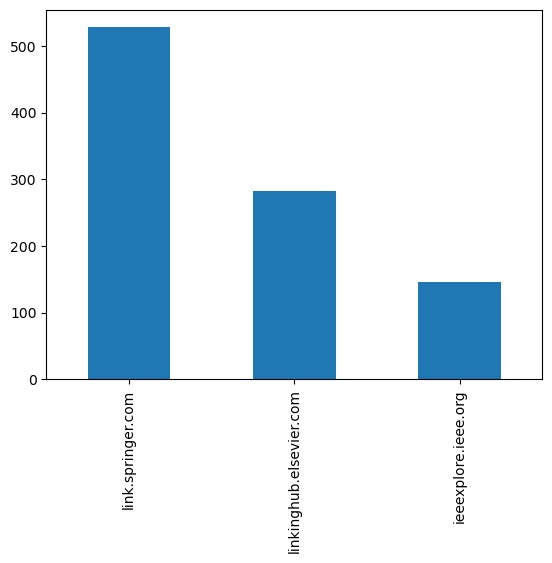

In [40]:
# describe domains_of_dois
df_domains_of_dois = pd.DataFrame(domains_of_dois)
# custom col name
df_domains_of_dois.columns = ['doi', 'domain']
# count the domains
counts = df_domains_of_dois['domain'].value_counts()
print(counts / len(df_domains_of_dois))
# plot
df_domains_of_dois['domain'].value_counts().plot(kind='bar')

In [62]:
# get all publications from domain 'link.springer.com' from final_scraping_result
springer_publications = [x for x in final_scraping_result if
                         x.get('url') is not None and domain(x.get('url')) == 'link.springer.com']
# create overview of all publication types
springer_publication_types = [x.get('publication_type') for x in springer_publications]
# count the publication types
counts = pd.Series(springer_publication_types).value_counts()
counts


Conference paper                       170
Chapter                                 79
Article                                 67
Book                                    33
Original Paper                          21
                                      ... 
Aufsatz                                  1
Short Survey Paper                       1
Special Issue Paper                      1
Klimaschutz und Co2-Emissionshandel      1
Kommentare                               1
Length: 64, dtype: int64

### Get authors with listed orcid

In [61]:
def get_orcid_authors(scraping_result):
    # search authors with orcid
    # get all authors
    all_authors = [x.get('authors') for x in scraping_result if x.get('authors') is not None]
    all_authors
    # flatten list
    all_authors = [item for sublist in all_authors for item in sublist]
    # authors with orcid
    authors_with_orcid = [x for x in all_authors if type(x) is not str and x.get('orcid') is not None]
    authors_with_orcid
    # remove duplicate double entries
    authors_with_orcid = list({v['orcid']: v for v in authors_with_orcid}.values())
    # sort by name
    authors_with_orcid = sorted(authors_with_orcid, key=lambda k: k['name'])

    return authors_with_orcid


authors_with_orcid = get_orcid_authors(final_scraping_result)

## Downloading pdf documents

In [18]:
final_scraping_result = scraping_results_imported_cleaned
# get {doi:doi, pdf_link:pdf} for all entries with pdf_link
all_found_pdf_links = [{'doi': x.get('doi'), 'pdf': x.get('pdf')} for x in final_scraping_result if
                       x.get('pdf') is not None]

In [19]:
import requests
import cloudscraper


def download_PDF(url, filename):
    headers = {  # todo make logic for this
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/15.5 Safari/605.1.15'}
    r = requests.get(url, headers=headers)

    # scraper = cloudscraper.create_scraper(
    #     browser={
    #         'custom': 'ScraperBot/1.0',
    #     }
    # )
    # r = scraper.get(url, allow_redirects=True)

    pdf_save_path = 'exports/pdf_downloads/' + filename + '.pdf'
    print(r.status_code)
    if r.status_code == 200:
        with open(pdf_save_path, 'wb') as f:
            f.write(r.content)
            # print green background black font
            print('\033[1;30;42m' + f'PDF downloaded : {filename}.pdf' + '\033[0m')
    else:
        print('Error: ', r.status_code)

In [23]:
test = all_found_pdf_links[0:10]

for i in test:
    # filename is doi without slashes
    filename = i.get('doi').replace('/', '_')
    download_PDF(i.get('pdf'), filename)


def download_publication:  #todo


200
PDF downloaded : 10.1007_978-3-7908-2336-3_5.pdf
200
PDF downloaded : 10.1007_978-3-642-03516-6_34.pdf
200
PDF downloaded : 10.1007_978-3-540-85204-9_11.pdf
200
PDF downloaded : 10.1007_978-3-642-11859-3_10.pdf
200
PDF downloaded : 10.1007_978-3-642-11859-3_11.pdf
200
PDF downloaded : 10.1007_s12525-010-0032-0.pdf
200
PDF downloaded : 10.1007_978-3-7908-2099-7.pdf
200
PDF downloaded : 10.1007_978-3-642-04840-1_6.pdf
200
PDF downloaded : 10.1007_978-3-642-04840-1_8.pdf
200
PDF downloaded : 10.1007_978-3-7908-1994-6_4.pdf
